In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


In [ ]:
%cd drive/MyDrive/Work

/content/drive/MyDrive/Work


In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'


  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-61ip8jpc
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-61ip8jpc
  Resolved https://github.com/facebookresearch/detectron2.git to commit 898507047cf441a1e4be7a729270961c401c4354
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6118663 sha256=b2af3ec5d765f25a7b464d0d2bd53

In [ ]:
import cv2
import numpy as np
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

def initialize_detectron2():
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
    predictor = DefaultPredictor(cfg)
    return predictor,cfg

def detect_person(frame, predictor,cfg):
    flag = 0
    outputs = predictor(frame)
    if "instances" not in outputs or len(outputs["instances"]) == 0:
        flag= 1
    v = Visualizer(frame[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    return flag,out.get_image()[:, :, ::-1]

def get_highest_area_bbox(predictor, frame):
    outputs = predictor(frame)
    if "instances" not in outputs or len(outputs["instances"]) == 0: return 0,0

    # Get the predictions
    instances = outputs["instances"].to("cpu")
    scores = instances.scores
    high_score = 0
    hi_idx = 0
    for i in range(len(instances.scores)):
      if scores[i]>high_score:
        high_score = scores[i]
        hi_idx = i

    # print(instances.pred_boxes[hi_idx])

    # Get the box with the highest confidence
    highest_conf_box = instances.pred_boxes[hi_idx].tensor
    # Return the center of the box
    center_x = (highest_conf_box[0][0] + highest_conf_box[0][2]) / 2
    center_y = (highest_conf_box[0][1] + highest_conf_box[0][3]) / 2

    return int(center_x),int(center_y)

def crop_and_resize_video(input_path, output_path, predictor,cfg):

    cap = cv2.VideoCapture(input_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    n_w = (int(height * 9 / 16))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps,(n_w,height))

    frame_count = 0
    while True:
      x_val =
        ret, frame = cap.read()
        if not ret:
            break

        # Detect persons and get the frame with bounding boxes
        flag,frame_with_boxes = detect_person(frame, predictor,cfg)
        x_ct,y_ct = get_highest_area_bbox(predictor, frame)
        x_val.append(x_ct)
        frame_count +=1
        if frame_count %40 == 0: print(frame_count)
        if frame_count == 1020 : break
        continue

        print(flag)
        if flag==1 : continue
        print(x_ct,y_ct,n_w,height)
        # break
        # Get the largest bounding box
        gray_frame = cv2.cvtColor(frame_with_boxes, cv2.COLOR_BGR2GRAY)
        contours, _ = cv2.findContours(gray_frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        largest_contour = max(contours, key=cv2.contourArea)

        # Get the bounding box of the largest contour
        x, y, w, h = cv2.boundingRect(largest_contour)
        print(n_w, height)



        # Write the resized frame to the output video
        frame_count +=1
        dot_color = (0, 255, 0)  # Green color
        center_coordinates = (x_ct,y_ct)
        # Define the radius of the dot
        radius = 5

        # Draw a dot on the image
        new_frame = cv2.circle(frame, center_coordinates, radius, dot_color, -1)

        # Crop the frame to the ROI
        if x_ct<(n_w/2):
          roi = new_frame[0:height, 0:n_w]

        elif x_ct+int(n_w/2) > width:
          roi = new_frame[0:height, width-n_w:width]

        else:
          roi = new_frame[0:height, x_ct-int(n_w/2):x_ct+int(n_w/2)]

        # Resize the frame to 9:16
        # resized_frame = cv2.resize(roi, (n_w,height))
        image_filename = f"final_frames/frame_{frame_count:04d}.jpg"
        cv2.imwrite(image_filename, roi)
        out.write(roi)

    cap.release()
    out.release()

if __name__ == "__main__":
    input_video_path = "demo.mp4"
    output_video_path = "output_video.mp4"

    predictor,cfg = initialize_detectron2()
    crop_and_resize_video(input_video_path, output_video_path, predictor,cfg)


SyntaxError: ignored

In [ ]:
import cv2
import numpy as np
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

def initialize_detectron2():
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
    predictor = DefaultPredictor(cfg)
    return predictor,cfg

def stabilize_plot(data, window_size):
    rolling_avg = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    stabilized_points = rolling_avg[:len(data)]  # Trim to match the length of the original data
    return stabilized_points

def detect_person(frame, predictor,cfg):
    flag = 0
    outputs = predictor(frame)
    if "instances" not in outputs or len(outputs["instances"]) == 0:
        flag= 1
    v = Visualizer(frame[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    return flag,out.get_image()[:, :, ::-1]

def get_highest_area_bbox(predictor, frame):

    outputs = predictor(frame)
    if "instances" not in outputs or len(outputs["instances"]) == 0: return 0,0,0

    # Get the predictions
    instances = outputs["instances"].to("cpu")
    scores = instances.scores
    high_score = 0
    hi_idx = 0
    for i in range(len(instances.scores)):
      if scores[i]>high_score:
        high_score = scores[i]
        hi_idx = i

    # print(instances.pred_boxes[hi_idx])

    # Get the box with the highest confidence
    highest_conf_box = instances.pred_boxes[hi_idx].tensor
    # Return the center of the box
    center_x = (highest_conf_box[0][0] + highest_conf_box[0][2]) / 2
    center_y = (highest_conf_box[0][1] + highest_conf_box[0][3]) / 2

    # print(high_score)

    return int(center_x),int(center_y),float(high_score)

def crop_and_resize_video(input_path, output_path, predictor,cfg):

    cap = cv2.VideoCapture(input_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')

    frame_count = 0
    x_val = []
    y_val = []
    scores = []
    while True:

      ret, frame = cap.read()
      if not ret:
          break

      # Detect persons and get the frame with bounding boxes
      flag,frame_with_boxes = detect_person(frame, predictor,cfg)
      x_ct,y_ct,hi_score = get_highest_area_bbox(predictor, frame)
      x_val.append(x_ct)
      y_val.append(y_ct)
      scores.append(hi_score)
      frame_count +=1
      if frame_count %40 ==0:print(frame_count)
      if frame_count == 2500 : break
      continue
    cap.release()

    window_size= 8
    x_val_stb = stabilize_plot(x_val, window_size)
    x_val_stb = [int(x) for x in x_val_stb]

    return x_val_stb,y_val,scores

def make_frames(x_val_stb,y_val,scores,input_path, output_path):
    #stabilizing factor
    p =0.5
    diff= 0
    cap = cv2.VideoCapture(input_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    n_w = (int(height * 9 / 16))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps,(n_w,height))

    frame_count = 0
    while True:

      ret, frame = cap.read()
      if not ret:
        break

      x_val_stb[frame_count] = int(x_val_stb[frame_count])


      if x_val_stb[frame_count] == 0:
        x_val_stb[frame_count] = int(width/2)
        # print(frame_count)

      # if scores[frame_count] <0.999:
      #   x_val_stb[frame_count] = x_val_stb[frame_count-1]
      if frame_count>0 and x_val_stb[frame_count-1]!=int(width/2):
        x_val_stb[frame_count] = int((x_val_stb[frame_count]+x_val_stb[frame_count -1])/2)

      if frame_count > 0:
        diff = x_val_stb[frame_count] - x_val_stb[frame_count-1]
        diff = diff*p
        x_val_stb[frame_count] =int(x_val_stb[frame_count-1] + diff)



      # if frame_count>0 and x_val_stb[frame_count-1]!=int(width/2):
      #   x_val_stb[frame_count] = int((x_val_stb[frame_count]+x_val_stb[frame_count -1])/2)




      print( x_val_stb[frame_count])

      # Write the resized frame to the output video
      if frame_count %40 ==0:print("Done with -",frame_count)
      dot_color = (0, 255, 0)  # Green color
      center_coordinates = (int(x_val_stb[frame_count]),y_val[frame_count])
      # Define the radius of the dot
      radius = 5

      # Draw a dot on the image
      new_frame = cv2.circle(frame, center_coordinates, radius, dot_color, -1)

      # Crop the frame to the ROI
      if x_val_stb[frame_count]<(n_w/2):
        roi = new_frame[0:height, 0:n_w]

      elif x_val_stb[frame_count]+int(n_w/2) > width:
        roi = new_frame[0:height, width-n_w:width]

      else:
        roi = new_frame[0:height, x_val_stb[frame_count]-int(n_w/2):x_val_stb[frame_count]+int(n_w/2)]
      frame_count +=1

      # Resize the frame to 9:16
      # resized_frame = cv2.resize(roi, (n_w,height))
      image_filename = f"final_frames/frame_{frame_count:04d}.jpg"
      cv2.imwrite(image_filename, roi)
      out.write(roi)
      if(frame_count) == len(x_val_stb)-1 : break


    cap.release()
    out.release()

if __name__ == "__main__":
    input_video_path = "demo.mp4"
    output_video_path = "output_video.mp4"

    predictor,cfg = initialize_detectron2()
    x_vals,y_val,scores = crop_and_resize_video(input_video_path, output_video_path, predictor,cfg)
    # print(scores)
    make_frames(x_vals,y_val,scores,input_video_path, output_video_path)


40
80
120
160
200
240
280
320
360
400
440
480
520
560
600
640
680
720
760
800
840
880
920
960
1000
1040
1080
1120
1160
1200
1240
1280
1320
1360
1400
1440
1480
1520
1560
1600
1640
1680
1720
1760
1800
1840
1880


In [ ]:
print(x_vals)
# for i in range(len(scores)) :
#   if scores[i]<0.999:
#     print(i)
# x_temp = x_vals

[960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960,

In [ ]:
# print(x_vals)

make_frames(x_temp,y_val,scores,input_video_path, output_video_path)

960
Done with - 0
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
Done with - 40
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
Done with - 80
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
Done with - 120
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
Done with - 160
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
Done with - 200
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960
960


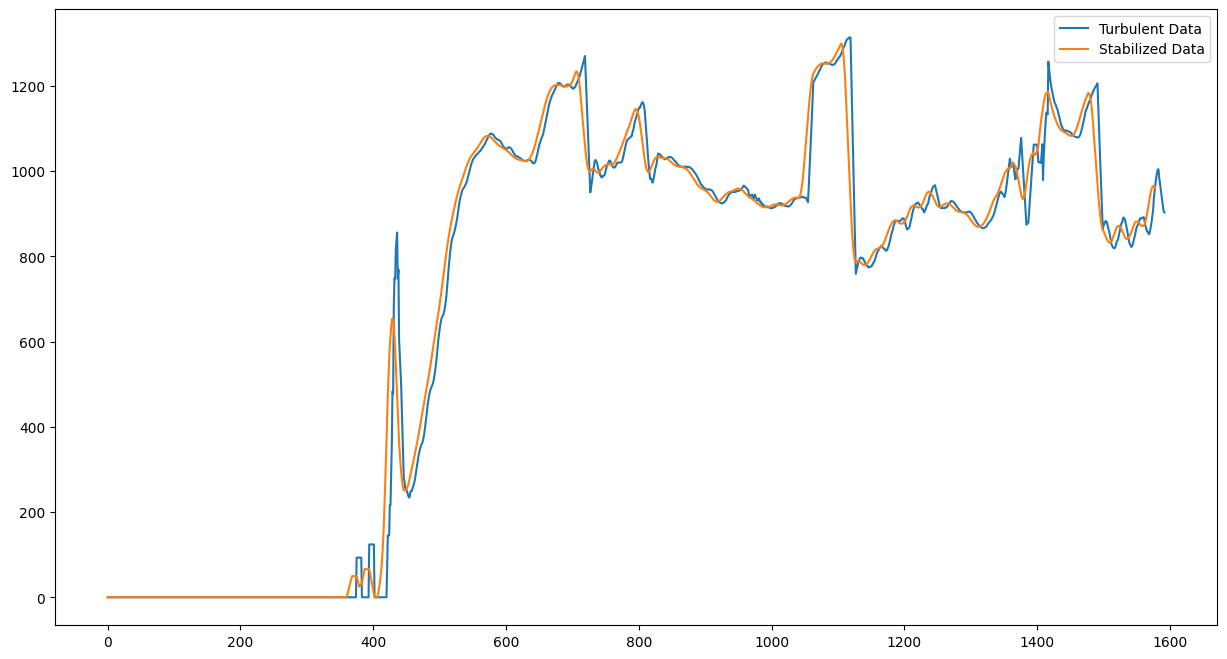

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def stabilize_plot(data, window_size):
    rolling_avg = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    stabilized_points = rolling_avg[:len(data)]  # Trim to match the length of the original data
    return stabilized_points

# Example usage
# Assuming 'turbulent_data' is your turbulent plot data
turbulent_data = np.random.normal(0, 1, 100)  # Replace this with your actual data
window_size = 15  # Adjust the window size as needed

stabilized_data = stabilize_plot(x_vals, window_size)

# Plotting the results
plt.figure(figsize=(15, 8))
plt.plot(x_vals, label='Turbulent Data')
plt.plot(stabilized_data, label='Stabilized Data')
plt.legend()
plt.show()

In [ ]:
print(len(x_vals),len(stabilized_data))

1593 1579


In [ ]:
import cv2
frame = cv2.imread("model_test.jpg")
h,w,_ = frame.shape
predictor,cfg = initialize_detectron2()
x,y = get_highest_area_bbox(predictor, frame)
x= int(x)
y=int(y)
n_w = int((h*9)/16)
print(x,y,h,w,n_w/2)
dot_color = (0, 255, 0)  # Green color
center_coordinates = (x,y)
# Define the radius of the dot
radius = 5

# Draw a dot on the image
# new_frame = cv2.circle(frame, center_coordinates, radius, dot_color, -1)
new_frame = frame[0:h,x-int(n_w/2):n_w]
cv2.imwrite("focused_img.jpg",new_frame)


473 357 667 1000 187.5


True

In [ ]:
import cv2
import os

def images_to_video(image_folder, video_name, fps=30):
    images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))

    # Setting the frame width, height width the width height of first image
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()

if __name__ == "__main__":
    image_folder = "final_frames"
    video_name = "demo_video3.mp4"
    images_to_video(image_folder, video_name)
